# Version 3 - Added Augmentation and Batch Norm

## 1. Imports

In [2]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [3]:
data_path = "./data"


## 3. Explore data

In [4]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'\\train\\'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'\\train\\'+class_name[1])

files_list_normal_test = get_list_files(data_path+'\\test\\'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'\\test\\'+class_name[1])

In [5]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1619, 1978)


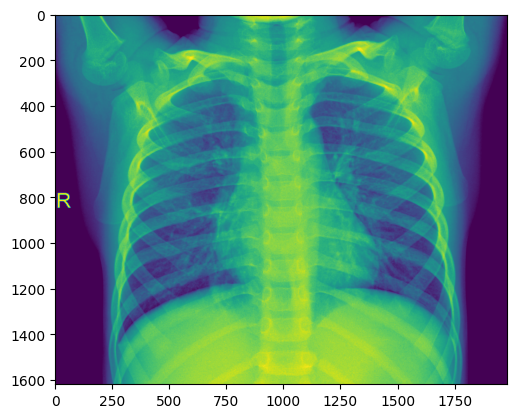

In [6]:
## get random file to check
img = data_path + '\\train\\NORMAL\\'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(744, 1120)


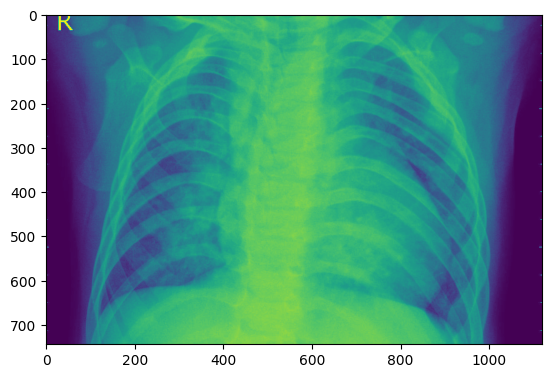

In [7]:
## get random file to check pneumona 
img = data_path + '\\train\\PNEUMONIA\\'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [10]:
path_to_image = data_path + '\\train\\PNEUMONIA\\'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
plt.imread(path_to_image).shape

(712, 1024)

In [11]:
cv2.imread(path_to_image).shape

(712, 1024, 3)

In [12]:
train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [13]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 4, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## 4. Define Model

In [14]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [15]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             R

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Train and Test function

In [17]:


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [18]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    #val_loss = 
    test(model, device, test_loader)

EPOCH number: 0


Loss=0.024541765451431274 Batch_id=1307 Accuracy=90.65: 100%|██████████| 1308/1308 [01:28<00:00, 14.78it/s] 


Current Learing Rate:  0.01

Test set: Average loss: 0.5347, Accuracy: 509/624 (81.57%)

EPOCH number: 1


Loss=0.01480384822934866 Batch_id=1307 Accuracy=93.50: 100%|██████████| 1308/1308 [01:28<00:00, 14.77it/s]   


Current Learing Rate:  0.01

Test set: Average loss: 0.5392, Accuracy: 514/624 (82.37%)

EPOCH number: 2


Loss=0.042188823223114014 Batch_id=1307 Accuracy=94.55: 100%|██████████| 1308/1308 [01:37<00:00, 13.37it/s]  


Current Learing Rate:  0.01

Test set: Average loss: 0.3611, Accuracy: 552/624 (88.46%)

EPOCH number: 3


Loss=0.013562758453190327 Batch_id=1307 Accuracy=94.90: 100%|██████████| 1308/1308 [01:30<00:00, 14.46it/s]  


Current Learing Rate:  0.01

Test set: Average loss: 0.3326, Accuracy: 548/624 (87.82%)

EPOCH number: 4


Loss=0.3618278205394745 Batch_id=1307 Accuracy=95.26: 100%|██████████| 1308/1308 [01:34<00:00, 13.80it/s]    


Current Learing Rate:  0.01

Test set: Average loss: 0.4922, Accuracy: 533/624 (85.42%)

EPOCH number: 5


Loss=0.08767110109329224 Batch_id=1307 Accuracy=95.68: 100%|██████████| 1308/1308 [01:51<00:00, 11.68it/s]   


Current Learing Rate:  0.005

Test set: Average loss: 0.4084, Accuracy: 536/624 (85.90%)

EPOCH number: 6


Loss=0.4453798234462738 Batch_id=1307 Accuracy=96.06: 100%|██████████| 1308/1308 [01:50<00:00, 11.85it/s]    


Current Learing Rate:  0.005

Test set: Average loss: 0.3064, Accuracy: 561/624 (89.90%)

EPOCH number: 7


Loss=0.0002278940664837137 Batch_id=1307 Accuracy=96.02: 100%|██████████| 1308/1308 [01:39<00:00, 13.20it/s] 


Current Learing Rate:  0.005

Test set: Average loss: 0.3597, Accuracy: 558/624 (89.42%)

EPOCH number: 8


Loss=0.0035352434497326612 Batch_id=1307 Accuracy=96.39: 100%|██████████| 1308/1308 [01:36<00:00, 13.61it/s] 


Current Learing Rate:  0.005

Test set: Average loss: 0.4048, Accuracy: 544/624 (87.18%)

EPOCH number: 9


Loss=0.04573196545243263 Batch_id=1307 Accuracy=96.10: 100%|██████████| 1308/1308 [01:40<00:00, 13.07it/s]   


Current Learing Rate:  0.005

Test set: Average loss: 0.5391, Accuracy: 527/624 (84.46%)

EPOCH number: 10


Loss=0.004714685492217541 Batch_id=1307 Accuracy=96.06: 100%|██████████| 1308/1308 [01:45<00:00, 12.41it/s]  


Current Learing Rate:  0.005

Test set: Average loss: 0.4335, Accuracy: 535/624 (85.74%)

EPOCH number: 11


Loss=0.008338387124240398 Batch_id=1307 Accuracy=96.44: 100%|██████████| 1308/1308 [01:49<00:00, 11.98it/s]  


Current Learing Rate:  0.0025

Test set: Average loss: 0.4313, Accuracy: 545/624 (87.34%)

EPOCH number: 12


Loss=0.0018158815801143646 Batch_id=1307 Accuracy=97.13: 100%|██████████| 1308/1308 [01:47<00:00, 12.13it/s] 


Current Learing Rate:  0.0025

Test set: Average loss: 0.5531, Accuracy: 522/624 (83.65%)

EPOCH number: 13


Loss=0.92745441198349 Batch_id=1307 Accuracy=96.98: 100%|██████████| 1308/1308 [01:47<00:00, 12.18it/s]      


Current Learing Rate:  0.0025

Test set: Average loss: 0.4445, Accuracy: 533/624 (85.42%)

EPOCH number: 14


Loss=1.344504952430725 Batch_id=1307 Accuracy=96.81: 100%|██████████| 1308/1308 [01:46<00:00, 12.25it/s]     


Current Learing Rate:  0.0025

Test set: Average loss: 0.3984, Accuracy: 546/624 (87.50%)



Text(0.5, 1.0, 'Test Accuracy')

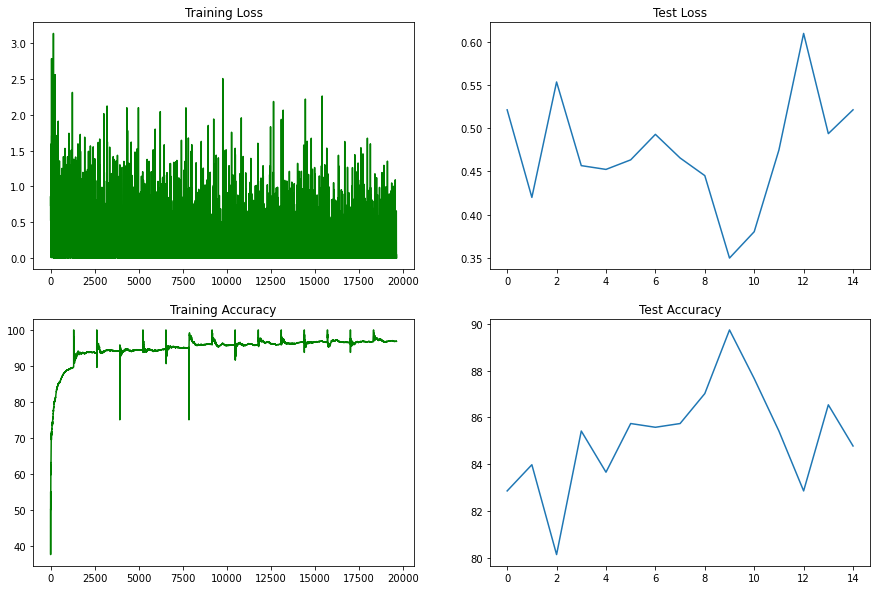

In [ ]:

torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")